In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


# Importing Libraries

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


from sklearn.metrics import plot_roc_curve,plot_precision_recall_curve,roc_auc_score,precision_recall_curve,roc_curve

from sklearn.metrics import auc

from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import RandomOverSampler,SMOTE

# Reading Dataset

In [3]:
df=pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Checking distribution of Class : Imbalanced

In [4]:
df.Class.value_counts()/len(df)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [5]:
#df.describe()

# Checking null values

In [6]:
df.isnull().sum().sum()

0

# Exploratory Data Analysis

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


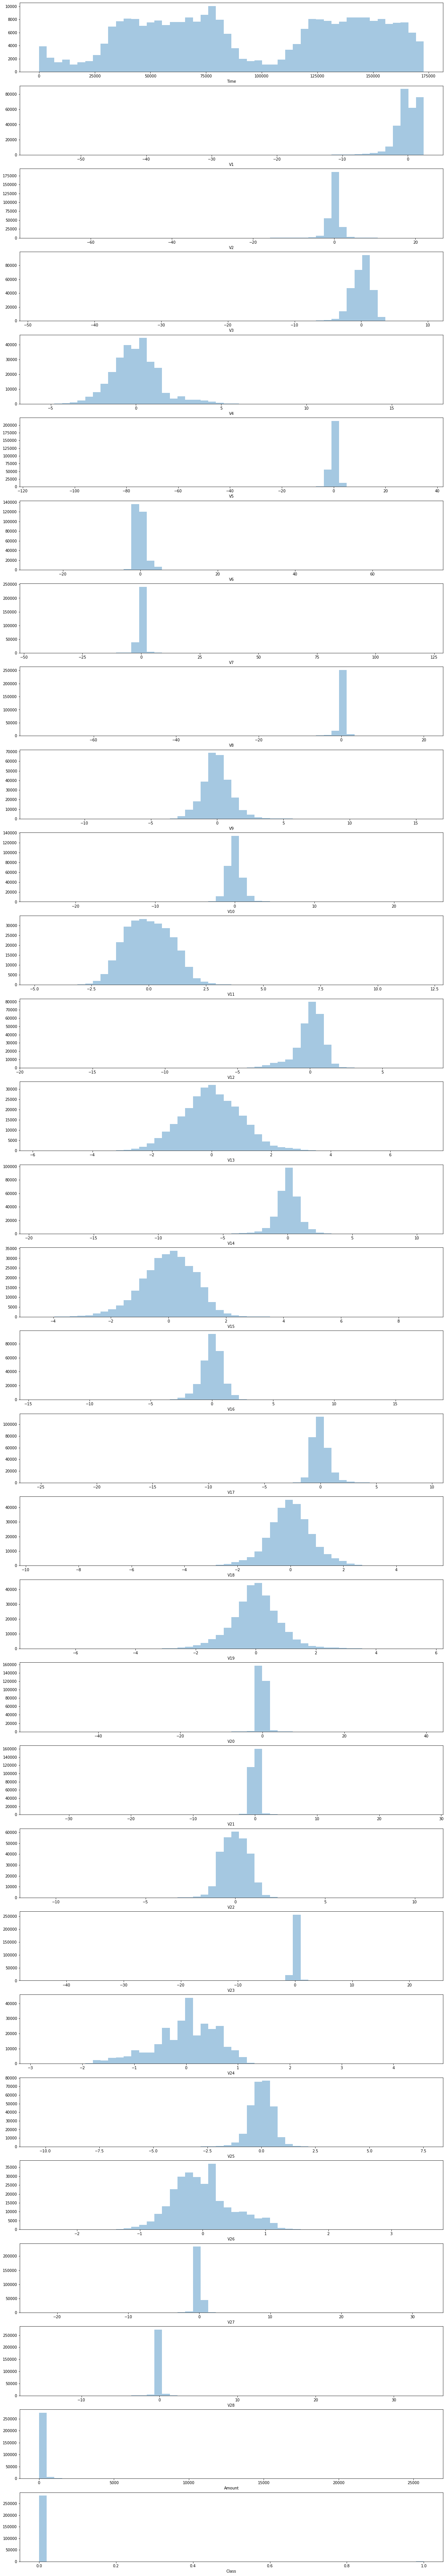

In [7]:
plt.figure(figsize=(20,len(df.columns)*4))
i=1
for cname in df.columns:
    plt.subplot(len(df.columns),1,i)
    sns.distplot(df[cname],kde=False)
    #plt.xlabel(df[cname])
    i=i+1
#plt.show()

Most of the data is centric around zero and having normal distribution except for features like time and amount

<AxesSubplot:xlabel='Class', ylabel='Amount'>

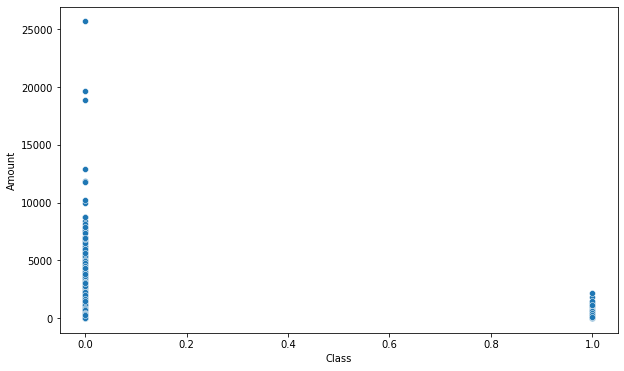

In [8]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df.Class,y=df.Amount)

**Fraud credit card transactions are usually of amount lower than 5000**

<AxesSubplot:xlabel='Time', ylabel='Amount'>

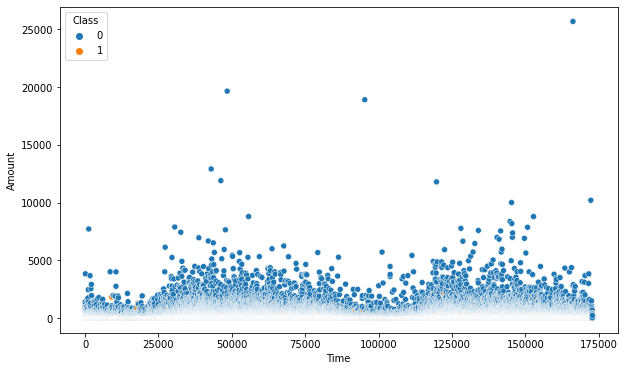

In [9]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df['Time'],y=df['Amount'],hue=df['Class'])

<AxesSubplot:xlabel='Time', ylabel='Amount'>

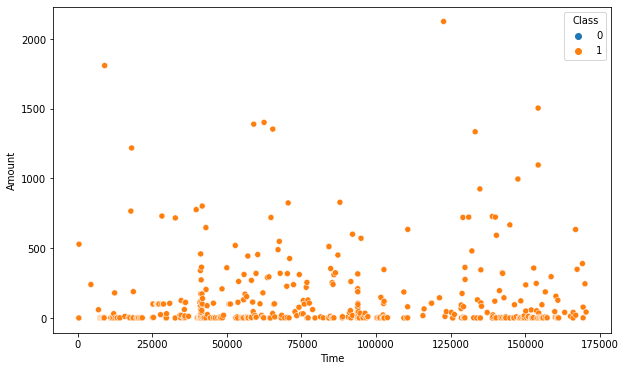

In [10]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df[df['Class']==1]['Time'],y=df[df['Class']==1]['Amount'],hue=df['Class'])

# Visualisation about distribution of Class

<AxesSubplot:ylabel='Class'>

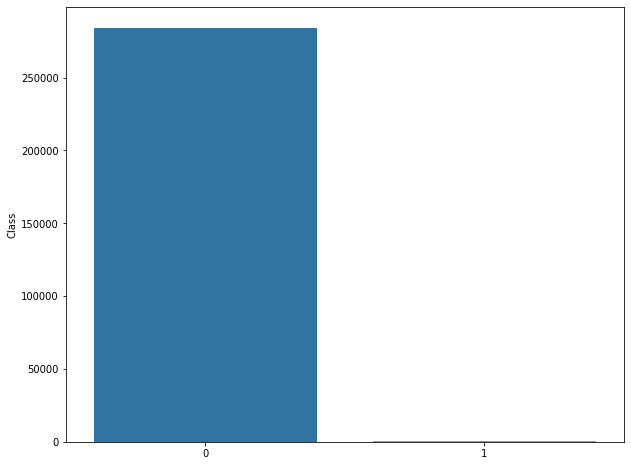

In [11]:
plt.figure(figsize=(10,8))
sns.barplot(x=df['Class'].value_counts().index,y=df['Class'].value_counts())

Imbalanced Class

# Visualising correlation

<AxesSubplot:>

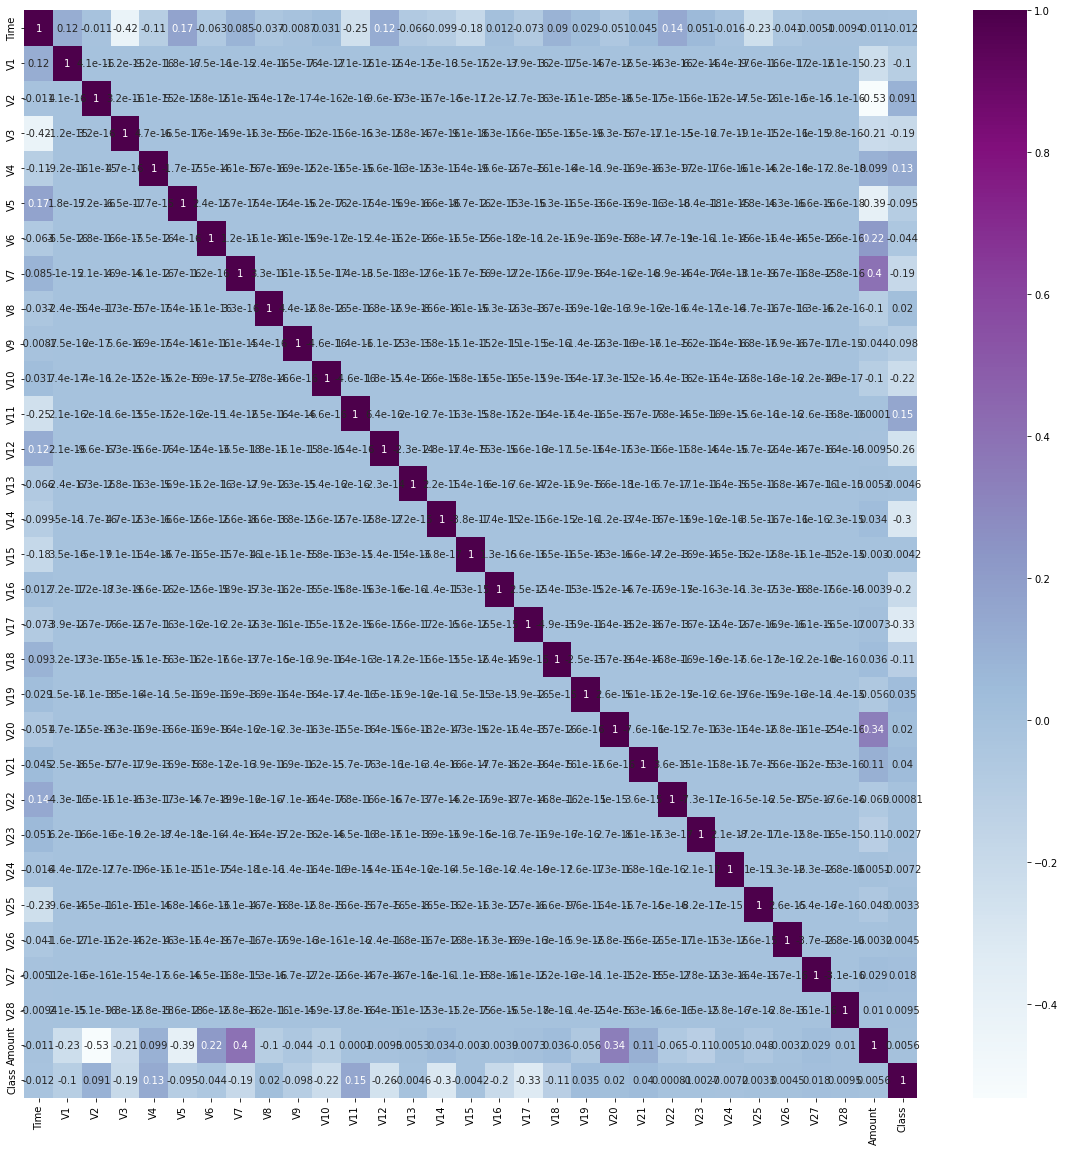

In [12]:
correlation=df.corr()

plt.figure(figsize=(20,20))
sns.heatmap(correlation,annot=True,cmap='BuPu')

Most of the data is equally important as correlation of features with Class lie almost in close range

V17,V14 & V12 are more correlated with Class

**Checking data types of features**

In [13]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [14]:
#sns.boxplot(x='Class',y='V1',data=df)

In [15]:
X=df.drop('Class',axis=1)
y=df.Class

# Stratified sampling of Class to handle Imbalanced Class

In [16]:
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,random_state=0)

In [17]:
X_train.shape

(213605, 30)

In [18]:
X_test.shape

(71202, 30)

In [19]:
y_train.value_counts()/len(y_train)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [20]:
y_test.value_counts()/len(y_test)

0    0.998273
1    0.001727
Name: Class, dtype: float64

# Training and Testing using XGBoost Model

In [21]:
model1=XGBClassifier()
model1.fit(X_train,y_train)
predictions1=model1.predict(X_test)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:09:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [22]:
print('Accuracy score: \t',accuracy_score(y_test,predictions1))
print('Precision score: \t',precision_score(y_test,predictions1))
print('Recall score: \t',recall_score(y_test,predictions1))
print('F1 score: \t',f1_score(y_test,predictions1))
print('Confusion Matrix: \n',confusion_matrix(y_test,predictions1))
print('Classification Report: \n',classification_report(y_test,predictions1))

Accuracy score: 	 0.9995646189713772
Precision score: 	 0.9509803921568627
Recall score: 	 0.7886178861788617
F1 score: 	 0.8622222222222222
Confusion Matrix: 
 [[71074     5]
 [   26    97]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.95      0.79      0.86       123

    accuracy                           1.00     71202
   macro avg       0.98      0.89      0.93     71202
weighted avg       1.00      1.00      1.00     71202



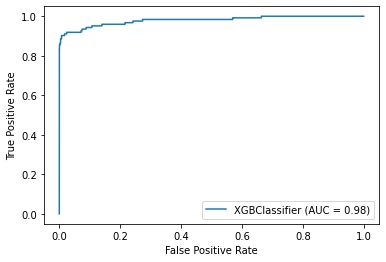

In [23]:
plot_roc_curve(model1,X_test,y_test)

In [24]:
y_score=model1.predict_proba(X_test)
y_score

array([[9.9999982e-01, 2.0309444e-07],
       [9.9999946e-01, 5.2506937e-07],
       [9.9999952e-01, 4.5059792e-07],
       ...,
       [9.9999946e-01, 5.6247495e-07],
       [9.9999881e-01, 1.1824593e-06],
       [9.9993312e-01, 6.6889545e-05]], dtype=float32)

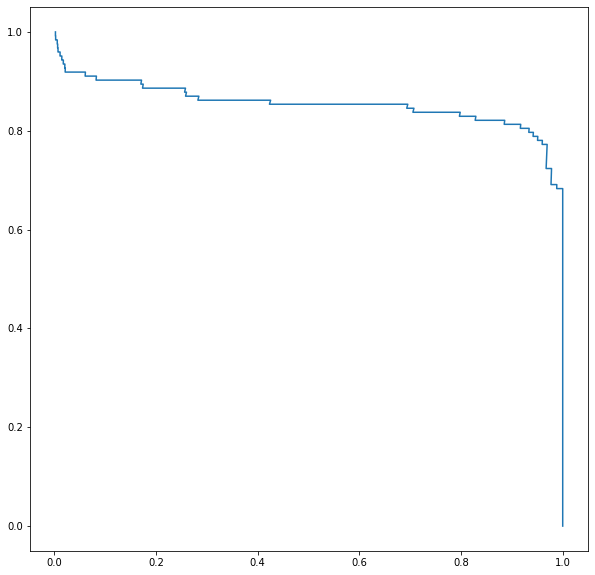

In [25]:
precision,recall,thresholds=precision_recall_curve(y_test,y_score[:,1])
plt.figure(figsize=(10,10))
plt.plot(precision,recall,label='Precision-Recall-Curve')


auc= 0.9795074002738509


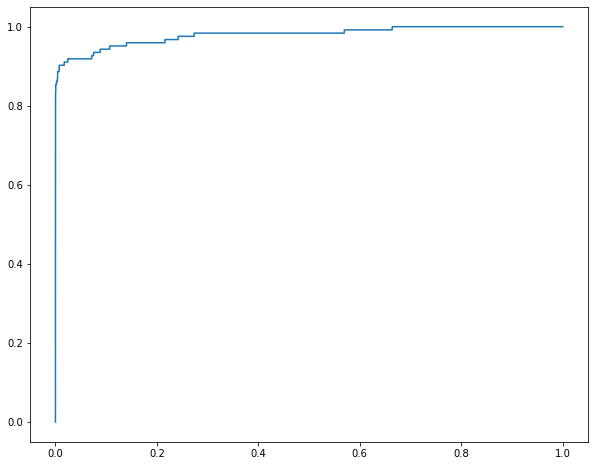

In [26]:
fpr,tpr,_=roc_curve(y_test,y_score[:,1])
plt.figure(figsize=(10,8))
plt.plot(fpr,tpr)
auc_xgb=auc(fpr,tpr)
print('auc=',auc_xgb)


In [27]:
XGFeaImp=pd.Series(model1.feature_importances_,index=X_train.columns)
XGFeaImp.sort_values(ascending=False)[:15]

V17       0.439175
V14       0.053902
V10       0.038767
V27       0.033339
V12       0.030691
V4        0.028153
V3        0.024837
V5        0.024296
V8        0.022833
V26       0.019684
V16       0.018476
Amount    0.018415
V7        0.018330
V13       0.017920
Time      0.016823
dtype: float32

# Training and Testing using RandomForest Model

In [28]:
model2=RandomForestClassifier()
model2.fit(X_train,y_train)
predictions2=model2.predict(X_test)

In [29]:
y_score2=model2.predict_proba(X_test)

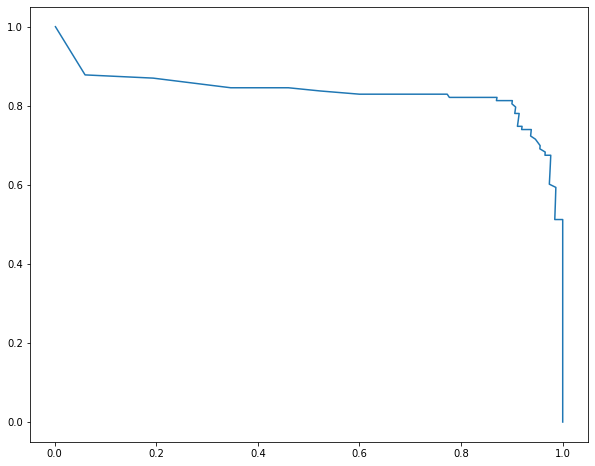

In [30]:
precision,recall,thresholds=precision_recall_curve(y_test,y_score2[:,1])
plt.figure(figsize=(10,8))
plt.plot(precision,recall)

0.9372984393753109


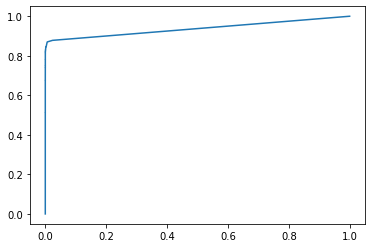

In [31]:
fpr,tpr,_=roc_curve(y_test,y_score2[:,1])
plt.plot(fpr,tpr)
auc_rf=auc(fpr,tpr)
print(auc_rf)

In [32]:
print('Accuracy score: \t',accuracy_score(y_test,predictions2))
print('Precision score: \t',precision_score(y_test,predictions2))
print('Recall score: \t',recall_score(y_test,predictions2))
print('F1 score: \t',f1_score(y_test,predictions2))
print('Confusion Matrix: \n',confusion_matrix(y_test,predictions2))
print('Classification Report: \n',classification_report(y_test,predictions2))

Accuracy score: 	 0.9994382180275835
Precision score: 	 0.9368421052631579
Recall score: 	 0.7235772357723578
F1 score: 	 0.81651376146789
Confusion Matrix: 
 [[71073     6]
 [   34    89]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.94      0.72      0.82       123

    accuracy                           1.00     71202
   macro avg       0.97      0.86      0.91     71202
weighted avg       1.00      1.00      1.00     71202



In [33]:
RFFeaImp=pd.Series(model2.feature_importances_,index=X_train.columns)
RFFeaImp.sort_values(ascending=False)[:15]

V17    0.173561
V14    0.119638
V12    0.112584
V10    0.100237
V16    0.069780
V9     0.049225
V11    0.043230
V4     0.026822
V18    0.025174
V21    0.025136
V7     0.022858
V2     0.018133
V26    0.017123
V3     0.016509
V20    0.014728
dtype: float64

# Training and Testing using LogisticRegression Model

In [34]:
model3=LogisticRegression(solver='liblinear')
model3.fit(X_train,y_train)
predictions3=model3.predict(X_test)

In [35]:
print('Accuracy score: \t',accuracy_score(y_test,predictions3))
print('Precision score: \t',precision_score(y_test,predictions3))
print('Recall score: \t',recall_score(y_test,predictions3))
print('F1 score: \t',f1_score(y_test,predictions3))
print('Confusion Matrix: \n',confusion_matrix(y_test,predictions3))
print('Classification Report: \n',classification_report(y_test,predictions3))

Accuracy score: 	 0.9988202578579254
Precision score: 	 0.7010309278350515
Recall score: 	 0.5528455284552846
F1 score: 	 0.6181818181818182
Confusion Matrix: 
 [[71050    29]
 [   55    68]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.70      0.55      0.62       123

    accuracy                           1.00     71202
   macro avg       0.85      0.78      0.81     71202
weighted avg       1.00      1.00      1.00     71202



0.9372984393753109


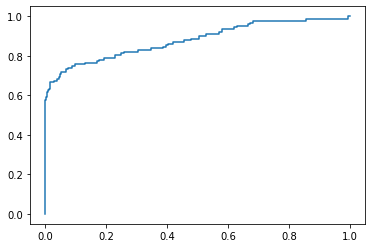

In [36]:
y_score3=model3.decision_function(X_test)

fpr3,tpr3,threshold3=roc_curve(y_test,y_score3)

plt.plot(fpr3,tpr3)

auc_lr=auc(fpr,tpr)
print(auc_lr)

0.9372984393753109


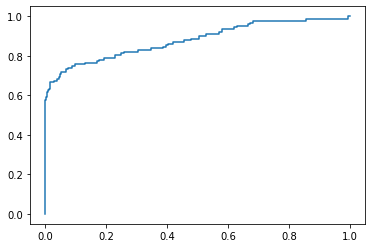

In [37]:
y_score3=model3.predict_proba(X_test)

fpr3,tpr3,threshold3=roc_curve(y_test,y_score3[:,1])

plt.plot(fpr3,tpr3)

auc_lr=auc(fpr,tpr)
print(auc_lr)

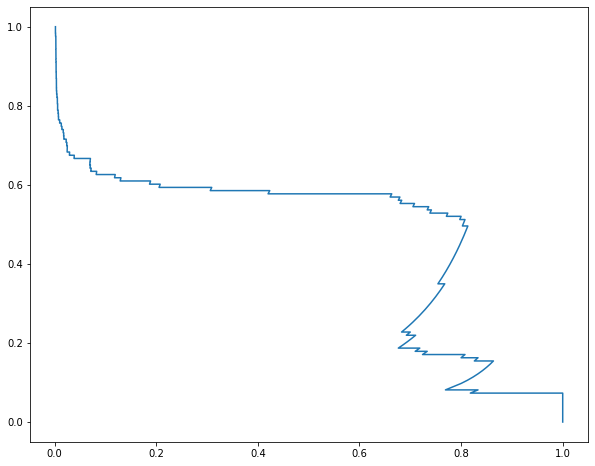

In [38]:
precision3,recall3,thresholds=precision_recall_curve(y_test,y_score3[:,1])
plt.figure(figsize=(10,8))
plt.plot(precision3,recall3)

In [39]:
LRFeaImp=pd.Series((model3.coef_).reshape(30),index=X_train.columns)
LRFeaImp=abs(LRFeaImp)
LRFeaImp.sort_values(ascending=False)[:15]

V3     0.685314
V14    0.632850
V17    0.423827
V9     0.342044
V2     0.262261
V13    0.236150
V16    0.228912
V10    0.194871
V4     0.138843
V22    0.138676
V15    0.132647
V25    0.104862
V21    0.104235
V11    0.103937
V1     0.101357
dtype: float64

# Training and Testing using SVC Model

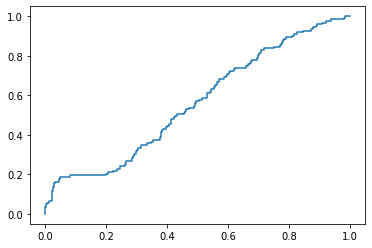

In [40]:
model4=SVC()
model4.fit(X_train,y_train)
predictions4=model4.predict(X_test)

y_score4=model4.decision_function(X_test)

fpr4,tpr4,threshold4=roc_curve(y_test,y_score4)
plt.plot(fpr4,tpr4)

# Hyper Parameter Tuning

Selecting XGBoost model for hyperparameter tuning because it led to better results

In [41]:
'''params_grid={'n_estimators':[100,150],'reg_lambda':[1,2],'learning_rate':[0.3,0.1],'max_depth':[5,6],'subsample':[0.9,1],'gamma':[0,1]}

gscv=GridSearchCV(estimator=XGBClassifier(),param_grid=params_grid,scoring='roc_auc',cv=2,verbose=0)

gscv.fit(X_train,y_train)'''

#gscv.best_estimator_

#print(gscv.best_params_)

"params_grid={'n_estimators':[100,150],'reg_lambda':[1,2],'learning_rate':[0.3,0.1],'max_depth':[5,6],'subsample':[0.9,1],'gamma':[0,1]}\n\ngscv=GridSearchCV(estimator=XGBClassifier(),param_grid=params_grid,scoring='roc_auc',cv=2,verbose=0)\n\ngscv.fit(X_train,y_train)"

In [42]:
tuned_model=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=1, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=2, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [43]:
tuned_model.fit(X_train,y_train)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:15:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=1, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=2, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [44]:
predictionsfinal=tuned_model.predict(X_test)

In [45]:
y_score=tuned_model.predict_proba(X_test)

AUC is 0.9791398943829476


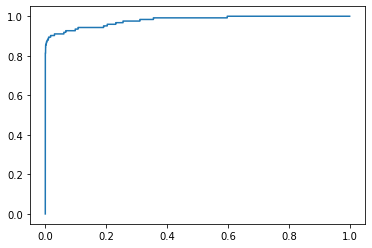

In [46]:
fpr,tpr,thresholds=roc_curve(y_test,y_score[:,1])
plt.plot(fpr,tpr)
final_auc=auc(fpr,tpr)
print('AUC is',final_auc)

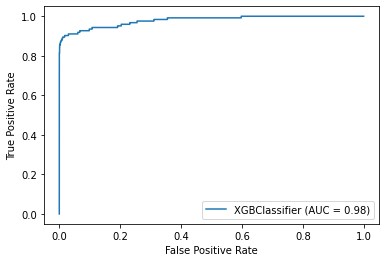

In [47]:
plot_roc_curve(tuned_model,X_test,y_test)

# Hyper-Parameter Tuning for Recall scoring

In [48]:
'''params_grid={'n_estimators':[100,150],'reg_lambda':[1,2],'learning_rate':[0.3,0.1],'max_depth':[5,6],'subsample':[0.9,1],'gamma':[0,1]}

gscv2=GridSearchCV(estimator=XGBClassifier(),param_grid=params_grid,scoring='recall',cv=2,verbose=1)

gscv2.fit(X_train,y_train)'''

#gscv2.best_estimator_

#gscv2.best_params_

"params_grid={'n_estimators':[100,150],'reg_lambda':[1,2],'learning_rate':[0.3,0.1],'max_depth':[5,6],'subsample':[0.9,1],'gamma':[0,1]}\n\ngscv2=GridSearchCV(estimator=XGBClassifier(),param_grid=params_grid,scoring='recall',cv=2,verbose=1)\n\ngscv2.fit(X_train,y_train)"

In [49]:
recall_model=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=2, scale_pos_weight=1, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [50]:
recall_model.fit(X_train,y_train)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:16:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=2, scale_pos_weight=1, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [51]:
predictionsrecall=recall_model.predict(X_test)

In [52]:
recall_score(y_test,predictionsrecall)

0.7804878048780488

# Over-Sampling(SMOTE) to handle Imbalanced Class

In [53]:
sampler=SMOTE()
X_over,y_over=sampler.fit_resample(X_train,y_train)

In [54]:
X_over.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,45539.0,-3.347914,-3.361473,1.544786,1.762811,2.669098,-1.163306,-0.894963,0.442753,-0.319186,...,1.537452,0.233390,-0.723999,0.944597,-0.594740,0.680832,-0.363141,-0.129965,0.149183,287.28
1,69211.0,-2.709431,-0.357075,0.764383,0.077630,-0.103980,-0.374977,-0.816368,0.791849,0.260995,...,-0.398313,0.069553,-0.026616,-0.828865,-0.316275,-0.500448,0.084505,-0.285052,-0.328693,15.95
2,82932.0,-1.043819,-0.296518,0.306696,-2.191146,1.281874,-0.340129,1.069963,0.032010,0.094097,...,0.331988,-0.125172,-0.751551,0.258923,-1.210583,0.008129,-1.144667,0.080121,0.137747,136.38
3,156757.0,-1.799744,-2.285001,-0.523871,-1.267247,1.618784,-0.791609,-1.090698,0.516999,-0.665132,...,0.706115,0.674089,1.182007,-0.509206,-0.183312,0.930281,0.308974,-0.121150,-0.455961,52.00
4,155597.0,1.998482,-0.249065,-1.253748,0.224398,0.041799,-0.589313,0.026386,-0.092081,0.437735,...,-0.221096,-0.255588,-0.718920,0.277660,-0.488993,-0.327426,0.209093,-0.081484,-0.073040,22.24


# EDA after Over-Sampling

<AxesSubplot:xlabel='Class', ylabel='Count'>

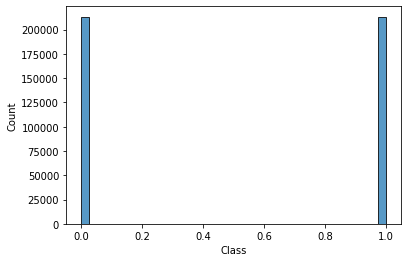

In [55]:
sns.histplot(y_over)

Class is balanced after over_sampling

<AxesSubplot:>

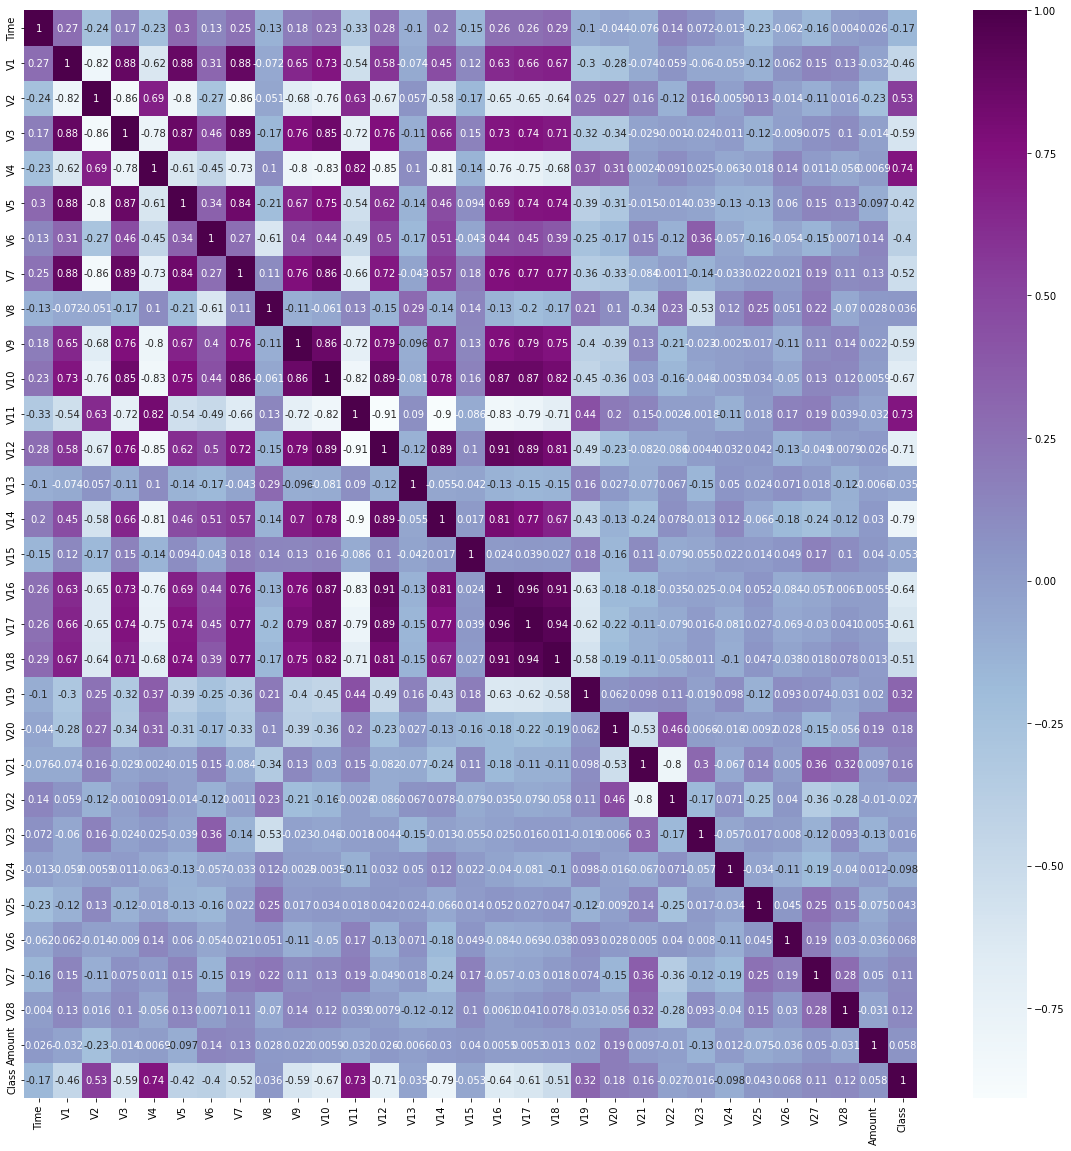

In [56]:
df2=pd.concat([X_over,y_over],axis=1)
correlation=df2.corr()

plt.figure(figsize=(20,20))
sns.heatmap(correlation,annot=True,cmap='BuPu')

Insights
1. After over_sampling the correlation among features and target variable has increased.
2. Features from V1 to V19 shows significant correlation with target variable

# Model Training and Testing with respect to over-sampled Dataset

In [57]:
model_over=XGBClassifier()
model_over.fit(X_over,y_over)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:17:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [58]:
predictions_over=model_over.predict(X_test)

# Important Features after over-sampling

In [59]:
XGBFeaImp_over=pd.Series(model_over.feature_importances_,index=X_over.columns)
XGBFeaImp_over.sort_values(ascending=False)[:15]

V14       0.714759
V4        0.035140
V12       0.034048
V17       0.025318
V3        0.015086
V8        0.012633
V10       0.012132
V1        0.011610
V13       0.010981
V9        0.009249
V11       0.009184
V18       0.008371
V28       0.007988
Time      0.007724
Amount    0.007563
dtype: float32

# Results

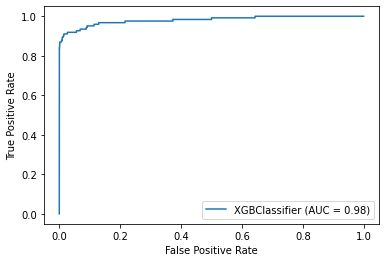

In [60]:
plot_roc_curve(model_over,X_test,y_test)

In [61]:
print('Accuracy score: \t',accuracy_score(y_test,predictions_over))
print('Precision score: \t',precision_score(y_test,predictions_over))
print('Recall score: \t',recall_score(y_test,predictions_over))
print('F1 score: \t',f1_score(y_test,predictions_over))
print('Confusion Matrix: \n',confusion_matrix(y_test,predictions_over))
print('Classification Report: \n',classification_report(y_test,predictions_over))

Accuracy score: 	 0.9994803516755147
Precision score: 	 0.864406779661017
Recall score: 	 0.8292682926829268
F1 score: 	 0.8464730290456431
Confusion Matrix: 
 [[71063    16]
 [   21   102]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.86      0.83      0.85       123

    accuracy                           1.00     71202
   macro avg       0.93      0.91      0.92     71202
weighted avg       1.00      1.00      1.00     71202

